# Import

In [1]:
import pandas as pd
import numpy as np

# Data

In [5]:
Train = pd.read_csv('/kaggle/input/covid-19-tweet/Train.csv', index_col='id')
Test = pd.read_csv('/kaggle/input/covid-19-tweet/Test.csv', index_col='id')
Validation = pd.read_csv('/kaggle/input/covid-19-tweet/Val.csv', index_col='id')

In [6]:
print(f"number of data in train set: {len(Train)}")
print(f"number of data in test set: {len(Test)}")
print(f"number of data in validation set: {len(Validation)}")

number of data in train set: 6420
number of data in test set: 2138
number of data in validation set: 2140


This is how the DataSet looks like. There are tweets and their related label as real or fake news.

In [24]:
Train.head()

,tweet,label
id,,
1,The CDC currently reports 99031 deaths. In gen...,real
2,States reported 1121 deaths a small rise from ...,real
3,Politically Correct Woman (Almost) Uses Pandem...,fake
4,#IndiaFightsCorona: We have 1524 #COVID testin...,real
5,Populous states can generate large case counts...,real


In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

- This is the distribution of tweet's lengths.
- As we can see, the distributions in Train, Test and Validation set are nearly the same.

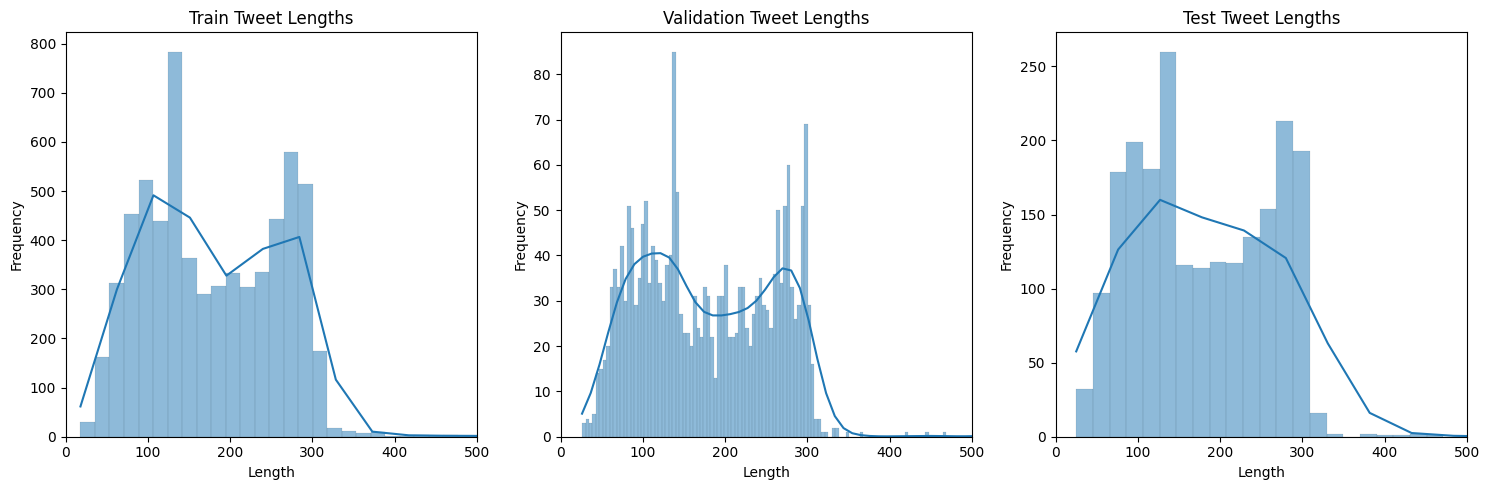

In [32]:
plt.figure(figsize=(15, 5))

# Plot for Train
plt.subplot(1, 3, 1)
ax1 = sns.histplot(Train['tweet'].apply(len), bins=500, kde=True)
ax1.set_xlim(0, 500)
plt.title('Train Tweet Lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')

# Plot for Validation
plt.subplot(1, 3, 2)
ax2 = sns.histplot(Validation['tweet'].apply(len), bins=500, kde=True)
ax2.set_xlim(0, 500)
plt.title('Validation Tweet Lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')

# Plot for Test
plt.subplot(1, 3, 3)
ax3 = sns.histplot(Test['tweet'].apply(len), bins=500, kde=True)
ax3.set_xlim(0, 500)
plt.title('Test Tweet Lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

- This is determining the ratio of real to fake new in different sets.
- It is clear from the plots that the number of fake and real news are nearly the same in sets.

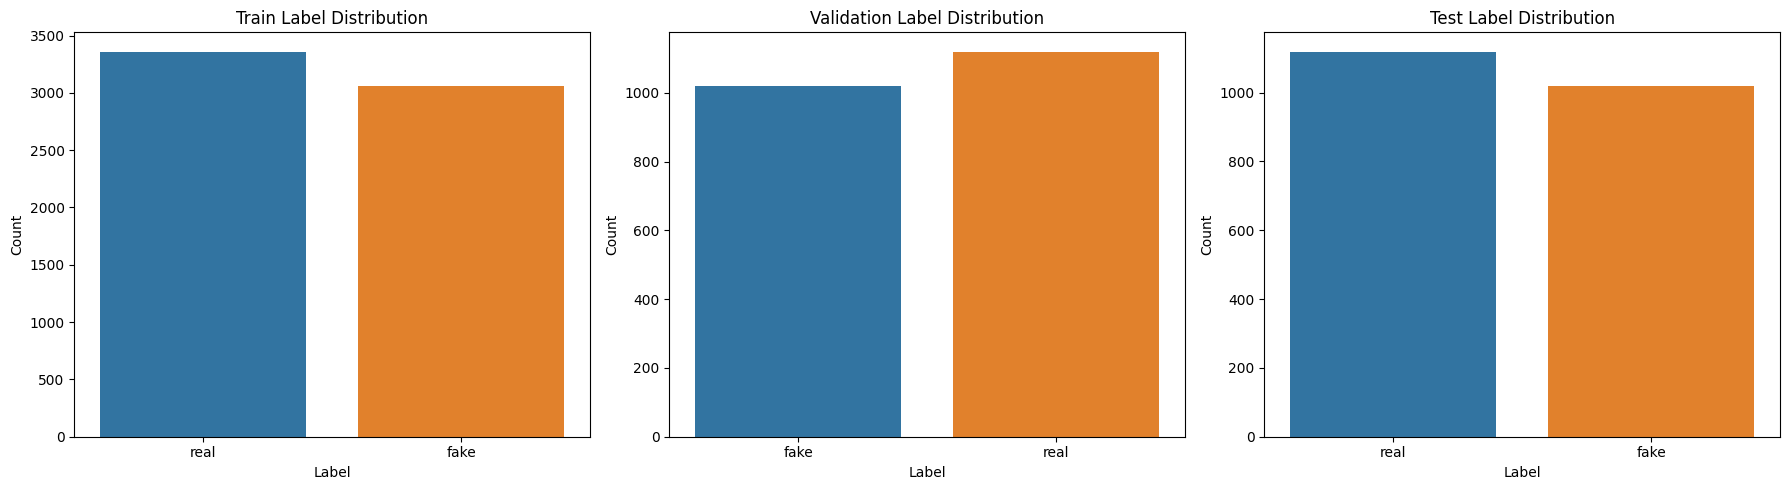

In [33]:
plt.figure(figsize=(18, 5))

# Plot for Train
plt.subplot(1, 3, 1)
sns.countplot(x='label', data=Train)
plt.title('Train Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')

# Plot for Validation
plt.subplot(1, 3, 2)
sns.countplot(x='label', data=Validation)
plt.title('Validation Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')

# Plot for Test
plt.subplot(1, 3, 3)
sns.countplot(x='label', data=Test)
plt.title('Test Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

# Preprocessing

In [ ]:
import re
import emoji
import string
from transformers import BertTokenizer, AutoTokenizer
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

In [8]:
def replace_emoji(tweet):
    return emoji.demojize(tweet)

In [10]:
def remove_html_and_urls(tweet):
    html_pattern = re.compile(r'<.*?>')
    url_pattern = re.compile(r'http\S+|www.\S+')
    tweet = html_pattern.sub(r'', tweet)
    tweet = url_pattern.sub(r'', tweet)
    return tweet

In [11]:
def remove_punctuations(tweet):
    return re.sub(r'[^\w\s]', '', tweet)

In [12]:
def remove_stopwords(tweet, tokenizer):
    stop_words = set(stopwords.words('english'))
    words = tokenizer.tokenize(tweet)
    
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return filtered_words

def stem_words(filtered_words, stemmer):
    
    stemmed_words = [stemmer.stem(word) for word in filtered_words]
    return stemmed_words

# Get the encodings using BERT or CT-BERT tokenizer
def get_mask_ids(text, tokenizer, max_length=128):
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=max_length,
        truncation=True,
        padding='max_length',
        return_attention_mask=True,
        return_token_type_ids=True,
        return_tensors='tf'
    )
    return encoding['input_ids'], encoding['attention_mask'], encoding['token_type_ids']

This is the preprocessing function. It applies all the above preprocessings to the Dataset.

In [13]:
def preprocessing(df, ct=False, max_length=128):
    if ct:
        tokenizer = BertTokenizer.from_pretrained('digitalepidemiologylab/covid-twitter-bert-v2')
    else:
        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    stemmer = PorterStemmer()
    
    df = df.copy()
    df['tweet'] = (df['tweet']
                   .apply(remove_html_and_urls)
                   .apply(replace_emoji)
                   .apply(remove_punctuations)
                   .apply(lambda x: remove_stopwords(x, tokenizer))
                   .apply(lambda x: stem_words(x, stemmer)))
    
    df[['input_ids', 'attention_mask', 'token_type_ids']] = df['tweet'].apply(
        lambda x: pd.Series(get_mask_ids(x, tokenizer)))
    return df

These are the preprocessed data using BERT tokenizer.

In [14]:
train = preprocessing(Train)
validation = preprocessing(Validation)
test = preprocessing(Test)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

2024-06-05 12:30:35.968235: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-05 12:30:35.968336: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-05 12:30:36.110954: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


These are the preprocessed data using CT-BERT tokenizer.

In [15]:
train_ct = preprocessing(Train, True)
validation_ct = preprocessing(Validation, True)
test_ct = preprocessing(Test, True)

tokenizer_config.json:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/421 [00:00<?, ?B/s]

In [16]:
train['target'] = 0
train.loc[train['label'] == 'real', 'target'] = 1
train = train.drop(columns=['label'])
validation['target'] = 0
validation.loc[validation['label'] == 'real', 'target'] = 1
validation = validation.drop(columns=['label'])
test['target'] = 0
test.loc[test['label'] == 'real', 'target'] = 1
test = test.drop(columns=['label'])

train_ct['target'] = 0
train_ct.loc[train_ct['label'] == 'real', 'target'] = 1
train_ct = train_ct.drop(columns=['label'])
validation_ct['target'] = 0
validation_ct.loc[validation_ct['label'] == 'real', 'target'] = 1
validation_ct = validation_ct.drop(columns=['label'])
test_ct['target'] = 0
test_ct.loc[test_ct['label'] == 'real', 'target'] = 1
test_ct = test_ct.drop(columns=['label'])

In [16]:
train.head()

,tweet,input_ids,attention_mask,token_type_ids,target
id,,,,,
1,"[cdc, current, report, 99, ##0, ##31, death, g...","((tf.Tensor(101, shape=(), dtype=int32), tf.Te...","((tf.Tensor(1, shape=(), dtype=int32), tf.Tens...","((tf.Tensor(0, shape=(), dtype=int32), tf.Tens...",1
2,"[state, report, 112, ##1, death, small, rise, ...","((tf.Tensor(101, shape=(), dtype=int32), tf.Te...","((tf.Tensor(1, shape=(), dtype=int32), tf.Tens...","((tf.Tensor(0, shape=(), dtype=int32), tf.Tens...",1
3,"[polit, correct, woman, almost, use, pan, ##de...","((tf.Tensor(101, shape=(), dtype=int32), tf.Te...","((tf.Tensor(1, shape=(), dtype=int32), tf.Tens...","((tf.Tensor(0, shape=(), dtype=int32), tf.Tens...",0
4,"[india, ##fight, ##sco, ##rona, 152, ##4, co, ...","((tf.Tensor(101, shape=(), dtype=int32), tf.Te...","((tf.Tensor(1, shape=(), dtype=int32), tf.Tens...","((tf.Tensor(0, shape=(), dtype=int32), tf.Tens...",1
5,"[popul, state, gener, larg, case, count, look,...","((tf.Tensor(101, shape=(), dtype=int32), tf.Te...","((tf.Tensor(1, shape=(), dtype=int32), tf.Tens...","((tf.Tensor(0, shape=(), dtype=int32), tf.Tens...",1


# Models

In [17]:
import tensorflow as tf
from transformers import TFBertModel
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

In [18]:
tf.random.set_seed(42)
np.random.seed(42)
np.random.seed(42)

Get the data really to feed the model.

In [19]:
train_input_ids = tf.convert_to_tensor(list(train['input_ids']), dtype=tf.int32)
train_attention_mask = tf.convert_to_tensor(list(train['attention_mask']), dtype=tf.int32)
train_token_type_ids = tf.convert_to_tensor(list(train['token_type_ids']), dtype=tf.int32)
train_target = tf.convert_to_tensor(list(train['target']), dtype=tf.float32)

val_input_ids = tf.convert_to_tensor(list(validation['input_ids']), dtype=tf.int32)
val_attention_mask = tf.convert_to_tensor(list(validation['attention_mask']), dtype=tf.int32)
val_token_type_ids = tf.convert_to_tensor(list(validation['token_type_ids']), dtype=tf.int32)
val_target = tf.convert_to_tensor(list(validation['target']), dtype=tf.float32)

test_input_ids = tf.convert_to_tensor(list(test['input_ids']), dtype=tf.int32)
test_attention_mask = tf.convert_to_tensor(list(test['attention_mask']), dtype=tf.int32)
test_token_type_ids = tf.convert_to_tensor(list(test['token_type_ids']), dtype=tf.int32)
test_target = tf.convert_to_tensor(list(test['target']), dtype=tf.float32)

In [20]:
train_input_ids = np.squeeze(train_input_ids, axis=1)
train_attention_mask = np.squeeze(train_attention_mask, axis=1)
train_token_type_ids = np.squeeze(train_token_type_ids, axis=1)

val_input_ids = np.squeeze(val_input_ids, axis=1)
val_attention_mask = np.squeeze(val_attention_mask, axis=1)
val_token_type_ids = np.squeeze(val_token_type_ids, axis=1)

test_input_ids = np.squeeze(test_input_ids, axis=1)
test_attention_mask = np.squeeze(test_attention_mask, axis=1)
test_token_type_ids = np.squeeze(test_token_type_ids, axis=1)

## Fine tuning: Model 1

In [21]:
class BertClassifier(tf.keras.Model):
    def __init__(self):
        super(BertClassifier, self).__init__()
        self.bert = TFBertModel.from_pretrained('bert-base-uncased')
        self.dense = tf.keras.layers.Dense(1, activation='sigmoid')
    
    def call(self, inputs):
        input_ids, attention_mask, token_type_ids = inputs
        bert_output = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        cls_output = bert_output.last_hidden_state[:, 0, :]
        dense_output = self.dense(cls_output)
        return dense_output
    
bert_dense_model = BertClassifier()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [22]:
bert_dense_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
                         loss=tf.keras.losses.BinaryCrossentropy(),
                         metrics=['accuracy'])

# Fit the model
history_1_fine = bert_dense_model.fit([train_input_ids, train_attention_mask, train_token_type_ids],
                                      train_target,
                                      validation_data=([val_input_ids, val_attention_mask, val_token_type_ids], val_target),
                                      epochs=3,
                                      batch_size=4)

Epoch 1/3


I0000 00:00:1717580008.264432     122 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1605/1605 [==============================] - 314s 140ms/step - loss: 0.2819 - accuracy: 0.8799 - val_loss: 0.1886 - val_accuracy: 0.9248
Epoch 2/3
1605/1605 [==============================] - 214s 133ms/step - loss: 0.1207 - accuracy: 0.9526 - val_loss: 0.1741 - val_accuracy: 0.9327
Epoch 3/3
1605/1605 [==============================] - 215s 134ms/step - loss: 0.0522 - accuracy: 0.9810 - val_loss: 0.2433 - val_accuracy: 0.9402


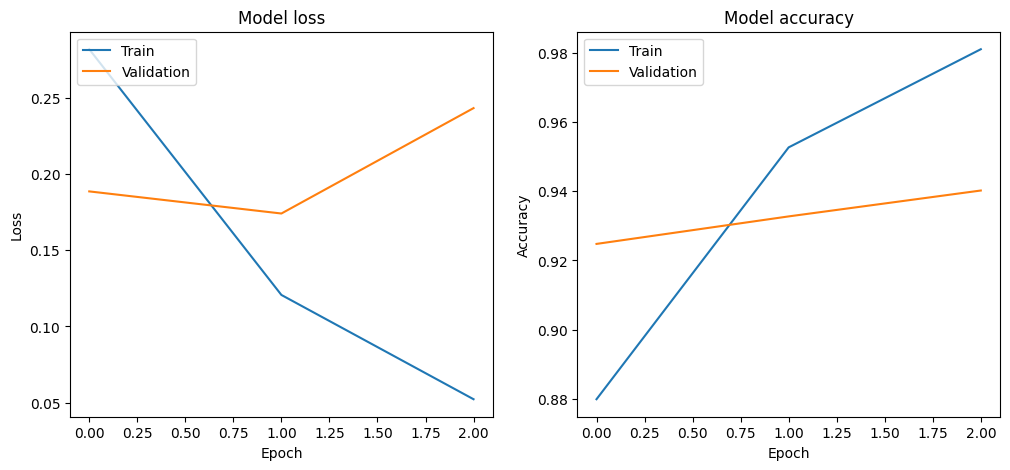

In [23]:
plt.figure(figsize=(12, 5))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history_1_fine.history['loss'])
plt.plot(history_1_fine.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history_1_fine.history['accuracy'])
plt.plot(history_1_fine.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

67/67 [==============================] - 30s 271ms/step
Test Accuracy: 0.9359214218896165
F1 Score: 0.9380930863081789
Confusion Matrix:


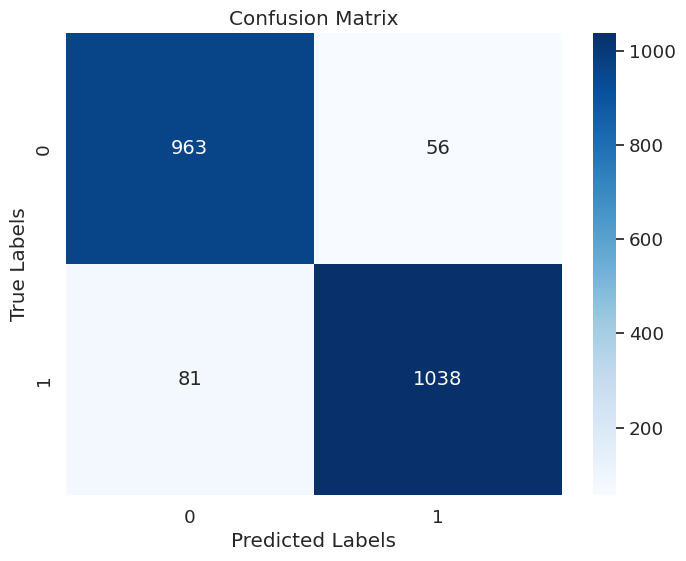

In [24]:
predictions_1_fine = bert_dense_model.predict([test_input_ids, test_attention_mask, test_token_type_ids])
predicted_labels_1_fine = (predictions_1_fine > 0.5).astype(int).flatten()

# Calculate accuracy, F1 score, and confusion matrix
accuracy_1_fine = accuracy_score(test_target, predicted_labels_1_fine)
f1_1_fine = f1_score(test_target, predicted_labels_1_fine)
conf_matrix_1_fine = confusion_matrix(test_target, predicted_labels_1_fine)

print(f'Test Accuracy: {accuracy_1_fine}')
print(f'F1 Score: {f1_1_fine}')
print('Confusion Matrix:')
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix_1_fine, annot=True, fmt="d", cmap="Blues", annot_kws={"size": 14})

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

plt.show()

## Fine tuning: Model 2

In [25]:
class BertBiGRUClassifier(tf.keras.Model):
    def __init__(self):
        super(BertBiGRUClassifier, self).__init__()
        self.bert = TFBertModel.from_pretrained('bert-base-uncased')
        self.bi_gru = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64))
        self.dense = tf.keras.layers.Dense(1, activation='sigmoid')

    def call(self, inputs):
        input_ids, attention_mask, token_type_ids = inputs
        bert_output = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        last_hidden_state = bert_output.last_hidden_state
        x = self.bi_gru(last_hidden_state)
        x = self.dense(x)
        return x

bert_gru_model = BertBiGRUClassifier()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [26]:
bert_gru_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
                          loss=tf.keras.losses.BinaryCrossentropy(),
                          metrics=['accuracy'])

history_1_gru = bert_gru_model.fit([train_input_ids, train_attention_mask, train_token_type_ids],
                                train_target,
                                validation_data=([val_input_ids, val_attention_mask, val_token_type_ids], val_target),
                                epochs=3,
                                batch_size=4)

Epoch 1/3
1605/1605 [==============================] - 312s 150ms/step - loss: 0.2768 - accuracy: 0.8824 - val_loss: 0.1845 - val_accuracy: 0.9271
Epoch 2/3
1605/1605 [==============================] - 229s 143ms/step - loss: 0.1197 - accuracy: 0.9555 - val_loss: 0.1544 - val_accuracy: 0.9393
Epoch 3/3
1605/1605 [==============================] - 231s 144ms/step - loss: 0.0484 - accuracy: 0.9838 - val_loss: 0.2421 - val_accuracy: 0.9355


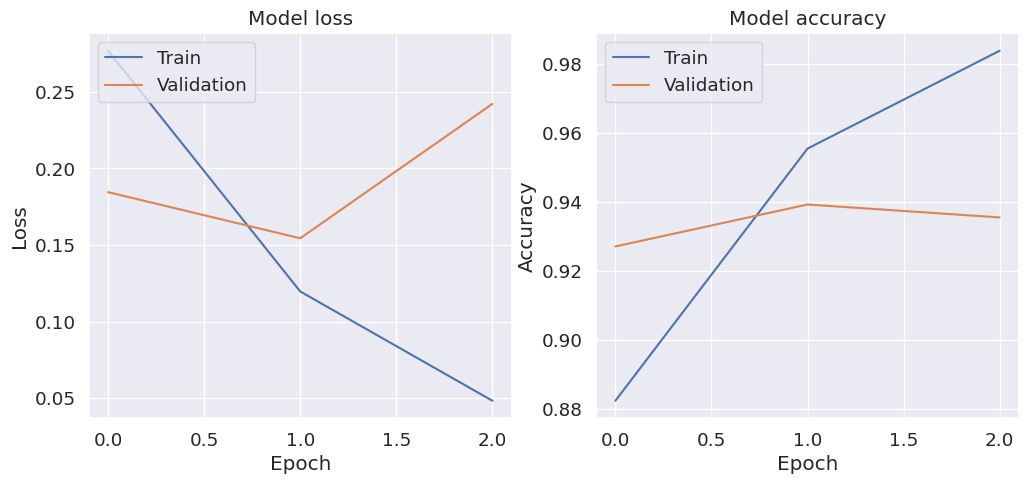

In [35]:
plt.figure(figsize=(12, 5))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history_1_gru.history['loss'])
plt.plot(history_1_gru.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history_1_gru.history['accuracy'])
plt.plot(history_1_gru.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

67/67 [==============================] - 31s 274ms/step
Test Accuracy: 0.9331150608044901
F1 Score: 0.9347329986307622
Confusion Matrix:


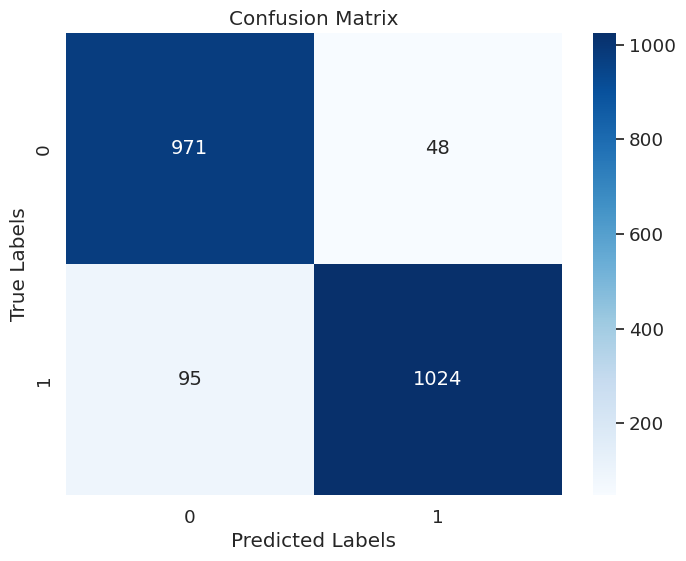

In [28]:
predictions_2_fine = bert_gru_model.predict([test_input_ids, test_attention_mask, test_token_type_ids])
predicted_labels_2_fine = (predictions_2_fine > 0.5).astype(int).flatten()

# Calculate accuracy, F1 score, and confusion matrix
accuracy_2_fine = accuracy_score(test_target, predicted_labels_2_fine)
f1_2_fine = f1_score(test_target, predicted_labels_2_fine)
conf_matrix_2_fine = confusion_matrix(test_target, predicted_labels_2_fine)

print(f'Test Accuracy: {accuracy_2_fine}')
print(f'F1 Score: {f1_2_fine}')
print('Confusion Matrix:')
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix_2_fine, annot=True, fmt="d", cmap="Blues", annot_kws={"size": 14})

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

plt.show()

## Fine tuning: Model 3

Get the data really to feed the model.

In [21]:
train_input_ids_ct = tf.convert_to_tensor(list(train_ct['input_ids']), dtype=tf.int32)
train_attention_mask_ct = tf.convert_to_tensor(list(train_ct['attention_mask']), dtype=tf.int32)
train_token_type_ids_ct = tf.convert_to_tensor(list(train_ct['token_type_ids']), dtype=tf.int32)
train_target_ct = tf.convert_to_tensor(list(train_ct['target']), dtype=tf.float32)

val_input_ids_ct = tf.convert_to_tensor(list(validation_ct['input_ids']), dtype=tf.int32)
val_attention_mask_ct = tf.convert_to_tensor(list(validation_ct['attention_mask']), dtype=tf.int32)
val_token_type_ids_ct = tf.convert_to_tensor(list(validation_ct['token_type_ids']), dtype=tf.int32)
val_target_ct = tf.convert_to_tensor(list(validation_ct['target']), dtype=tf.float32)

test_input_ids_ct = tf.convert_to_tensor(list(test_ct['input_ids']), dtype=tf.int32)
test_attention_mask_ct = tf.convert_to_tensor(list(test_ct['attention_mask']), dtype=tf.int32)
test_token_type_ids_ct = tf.convert_to_tensor(list(test_ct['token_type_ids']), dtype=tf.int32)
test_target_ct = tf.convert_to_tensor(list(test_ct['target']), dtype=tf.float32)

In [22]:
train_input_ids_ct = np.squeeze(train_input_ids_ct, axis=1)
train_attention_mask_ct = np.squeeze(train_attention_mask_ct, axis=1)
train_token_type_ids_ct = np.squeeze(train_token_type_ids_ct, axis=1)

val_input_ids_ct = np.squeeze(val_input_ids_ct, axis=1)
val_attention_mask_ct = np.squeeze(val_attention_mask_ct, axis=1)
val_token_type_ids_ct = np.squeeze(val_token_type_ids_ct, axis=1)

test_input_ids_ct = np.squeeze(test_input_ids_ct, axis=1)
test_attention_mask_ct = np.squeeze(test_attention_mask_ct, axis=1)
test_token_type_ids_ct = np.squeeze(test_token_type_ids_ct, axis=1)

In [23]:
class CTBertBiGRUClassifier(tf.keras.Model):
    def __init__(self):
        super(CTBertBiGRUClassifier, self).__init__()
        self.bert = TFBertModel.from_pretrained('digitalepidemiologylab/covid-twitter-bert')
        self.bi_gru = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64))
        self.dense = tf.keras.layers.Dense(1, activation='sigmoid')

    def call(self, inputs):
        input_ids, attention_mask, token_type_ids = inputs
        bert_output = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        last_hidden_state = bert_output.last_hidden_state
        x = self.bi_gru(last_hidden_state)
        x = self.dense(x)
        return x
    
ct_gru_model = CTBertBiGRUClassifier()

config.json:   0%|          | 0.00/421 [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/1.47G [00:00<?, ?B/s]

Some layers from the model checkpoint at digitalepidemiologylab/covid-twitter-bert were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at digitalepidemiologylab/covid-twitter-bert.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [24]:
ct_gru_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                      loss=tf.keras.losses.BinaryCrossentropy(),
                      metrics=['accuracy'])

history_1_ct_gru = ct_gru_model.fit([train_input_ids_ct, train_attention_mask_ct, train_token_type_ids_ct],
                                train_target_ct,
                                validation_data=([val_input_ids_ct, val_attention_mask_ct, val_token_type_ids_ct], val_target_ct),
                                epochs=3,
                                batch_size=4)

Epoch 1/3


I0000 00:00:1717590843.440379     125 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1605/1605 [==============================] - 884s 448ms/step - loss: 0.2248 - accuracy: 0.9065 - val_loss: 0.1324 - val_accuracy: 0.9463
Epoch 2/3
1605/1605 [==============================] - 696s 433ms/step - loss: 0.0594 - accuracy: 0.9791 - val_loss: 0.1979 - val_accuracy: 0.9430
Epoch 3/3
1605/1605 [==============================] - 696s 434ms/step - loss: 0.0259 - accuracy: 0.9922 - val_loss: 0.1960 - val_accuracy: 0.9491


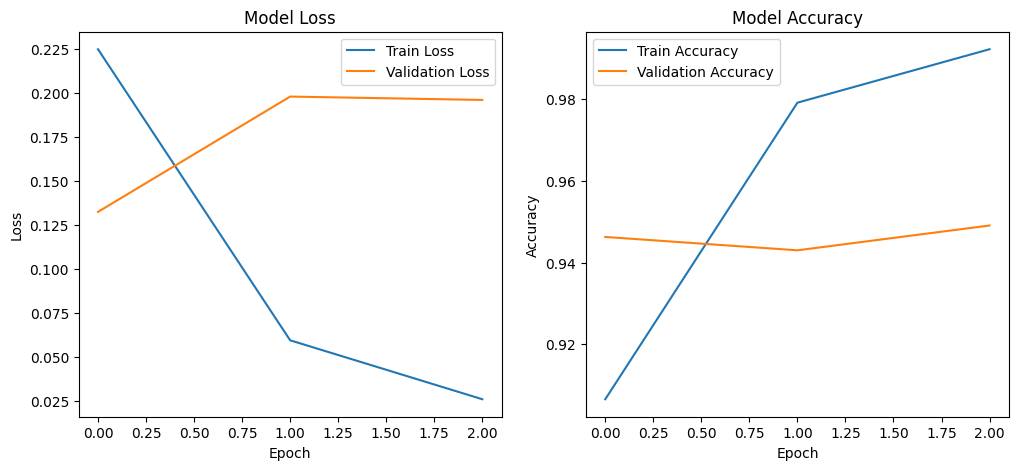

In [25]:
plt.figure(figsize=(12, 5))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history_1_ct_gru.history['loss'], label='Train Loss')
plt.plot(history_1_ct_gru.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history_1_ct_gru.history['accuracy'], label='Train Accuracy')
plt.plot(history_1_ct_gru.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

67/67 [==============================] - 84s 896ms/step
Test Accuracy: 0.9448082319925164
F1 Score: 0.9481546572934973
Confusion Matrix:


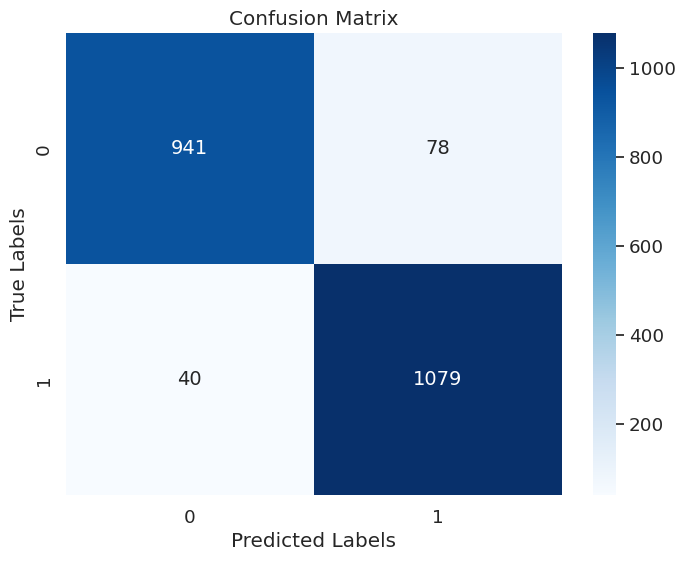

In [26]:
predictions_3_fine = ct_gru_model.predict([test_input_ids_ct, test_attention_mask_ct, test_token_type_ids_ct])
predicted_labels_3_fine = (predictions_3_fine > 0.5).astype(int).flatten()

# Calculate accuracy, F1 score, and confusion matrix
accuracy_3_fine = accuracy_score(test_target_ct, predicted_labels_3_fine)
f1_3_fine = f1_score(test_target_ct, predicted_labels_3_fine)
conf_matrix_3_fine = confusion_matrix(test_target_ct, predicted_labels_3_fine)

print(f'Test Accuracy: {accuracy_3_fine}')
print(f'F1 Score: {f1_3_fine}')
print('Confusion Matrix:')
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix_3_fine, annot=True, fmt="d", cmap="Blues", annot_kws={"size": 14})

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

plt.show()

## Feature-based: Model 1

In [ ]:
class BertClassifierFeatureBased(tf.keras.Model):
    def __init__(self):
        super(BertClassifierFeatureBased, self).__init__()
        self.bert = TFBertModel.from_pretrained('bert-base-uncased')
        self.bert.Trainable = False
        self.dense = tf.keras.layers.Dense(1, activation='sigmoid')
    
    def call(self, inputs):
        input_ids, attention_mask, token_type_ids = inputs
        bert_output = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        cls_output = bert_output.last_hidden_state[:, 0, :]
        dense_output = self.dense(cls_output)
        return dense_output
    
bert_dense_model_f = BertClassifierFeatureBased()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
bert_dense_model_f.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
                         loss=tf.keras.losses.BinaryCrossentropy(),
                         metrics=['accuracy'])

# Fit the model
history_1_feature = bert_dense_model_f.fit([train_input_ids, train_attention_mask, train_token_type_ids],
                                      train_target,
                                      validation_data=([val_input_ids, val_attention_mask, val_token_type_ids], val_target),
                                      epochs=3,
                                      batch_size=4)

Epoch 1/3


I0000 00:00:1717657647.809978     109 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1605/1605 [==============================] - 306s 138ms/step - loss: 0.2882 - accuracy: 0.8783 - val_loss: 0.1947 - val_accuracy: 0.9220
Epoch 2/3
1605/1605 [==============================] - 214s 133ms/step - loss: 0.1260 - accuracy: 0.9536 - val_loss: 0.1719 - val_accuracy: 0.9332
Epoch 3/3
1605/1605 [==============================] - 215s 134ms/step - loss: 0.0604 - accuracy: 0.9794 - val_loss: 0.2182 - val_accuracy: 0.9360


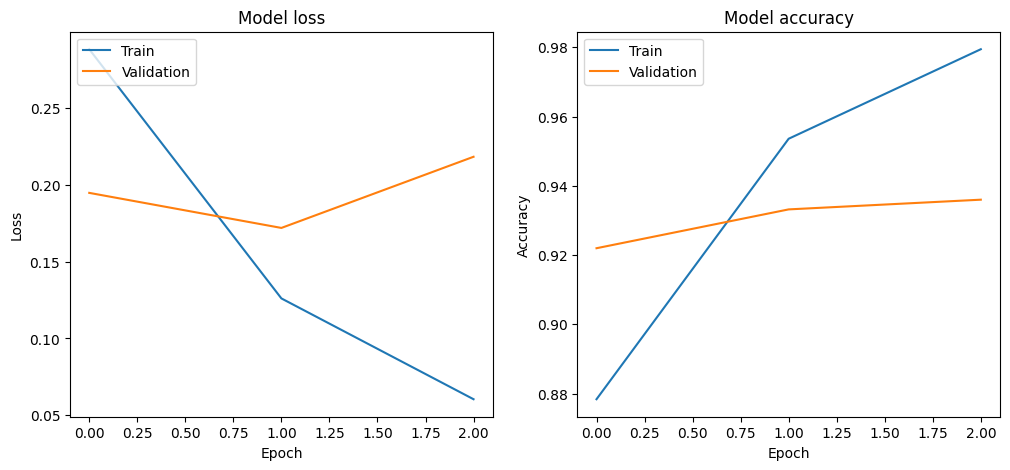

In [ ]:
plt.figure(figsize=(12, 5))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history_1_feature.history['loss'])
plt.plot(history_1_feature.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history_1_feature.history['accuracy'])
plt.plot(history_1_feature.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

67/67 [==============================] - 30s 274ms/step
Test Accuracy: 0.9359214218896165
F1 Score: 0.9385925593904079
Confusion Matrix:


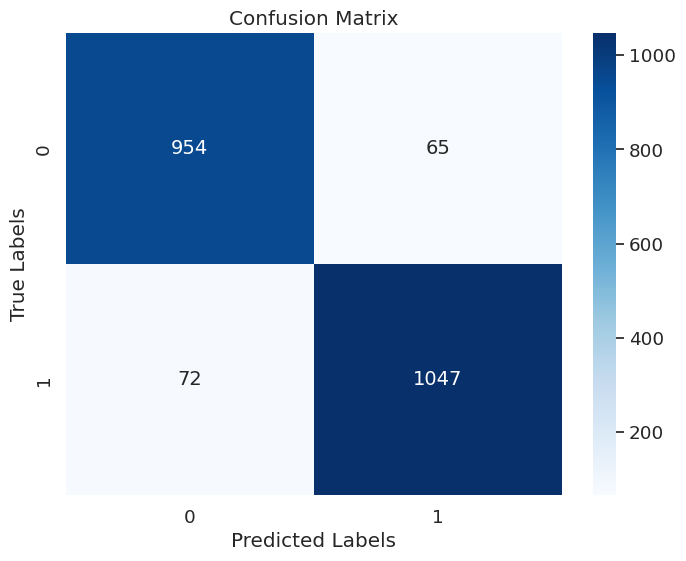

In [ ]:
predictions_1_feature = bert_dense_model_f.predict([test_input_ids, test_attention_mask, test_token_type_ids])
predicted_labels_1_feature = (predictions_1_feature > 0.5).astype(int).flatten()

# Calculate accuracy, F1 score, and confusion matrix
accuracy_1_feature= accuracy_score(test_target, predicted_labels_1_feature)
f1_1_feature = f1_score(test_target, predicted_labels_1_feature)
conf_matrix_1_feature = confusion_matrix(test_target, predicted_labels_1_feature)

print(f'Test Accuracy: {accuracy_1_feature}')
print(f'F1 Score: {f1_1_feature}')
print('Confusion Matrix:')
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix_1_feature, annot=True, fmt="d", cmap="Blues", annot_kws={"size": 14})

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

plt.show()

In [ ]:
predicted_real = predicted_labels_1_feature == 1
is_fake = test_target == 0
candidate = np.where(predicted_real & is_fake)

print(f"Tweet which predicted as real news but it is fake:\n {Test['tweet'][np.random.choice(candidate[0])]}")

Tweet which predicted as real news but it is fake:
 “If you have had a flu shot in the last 3-5 years you will probably test positive” for COVID-19.


In [ ]:
predicted_fake = predicted_labels_1_feature == 0
is_real = test_target == 1
candidate = np.where(predicted_fake & is_real)

print(f"Tweet which predicted as fake news but it is real:\n {Test['tweet'][np.random.choice(candidate[0])]}")

Tweet which predicted as fake news but it is real:
 A photo shows a 19-year-old vaccine for canine coronavirus that could be used to prevent the new coronavirus causing COVID-19.


## Feature-based: Model 2

In [ ]:
class BertBiGRUClassifierFeatureBased(tf.keras.Model):
    def __init__(self):
        super(BertBiGRUClassifierFeatureBased, self).__init__()
        self.bert = TFBertModel.from_pretrained('bert-base-uncased')
        self.bert.Trainable = False
        self.bi_gru = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64))
        self.dense = tf.keras.layers.Dense(1, activation='sigmoid')

    def call(self, inputs):
        input_ids, attention_mask, token_type_ids = inputs
        bert_output = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        last_hidden_state = bert_output.last_hidden_state
        x = self.bi_gru(last_hidden_state)
        x = self.dense(x)
        return x

bert_gru_model_f = BertBiGRUClassifierFeatureBased()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
bert_gru_model_f.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
                          loss=tf.keras.losses.BinaryCrossentropy(),
                          metrics=['accuracy'])

history_2_gru = bert_gru_model_f.fit([train_input_ids, train_attention_mask, train_token_type_ids],
                                train_target,
                                validation_data=([val_input_ids, val_attention_mask, val_token_type_ids], val_target),
                                epochs=3,
                                batch_size=4)

Epoch 1/3
1605/1605 [==============================] - 311s 152ms/step - loss: 0.2901 - accuracy: 0.8727 - val_loss: 0.1922 - val_accuracy: 0.9280
Epoch 2/3
1605/1605 [==============================] - 232s 145ms/step - loss: 0.1231 - accuracy: 0.9531 - val_loss: 0.1638 - val_accuracy: 0.9383
Epoch 3/3
1605/1605 [==============================] - 233s 145ms/step - loss: 0.0476 - accuracy: 0.9835 - val_loss: 0.1955 - val_accuracy: 0.9355


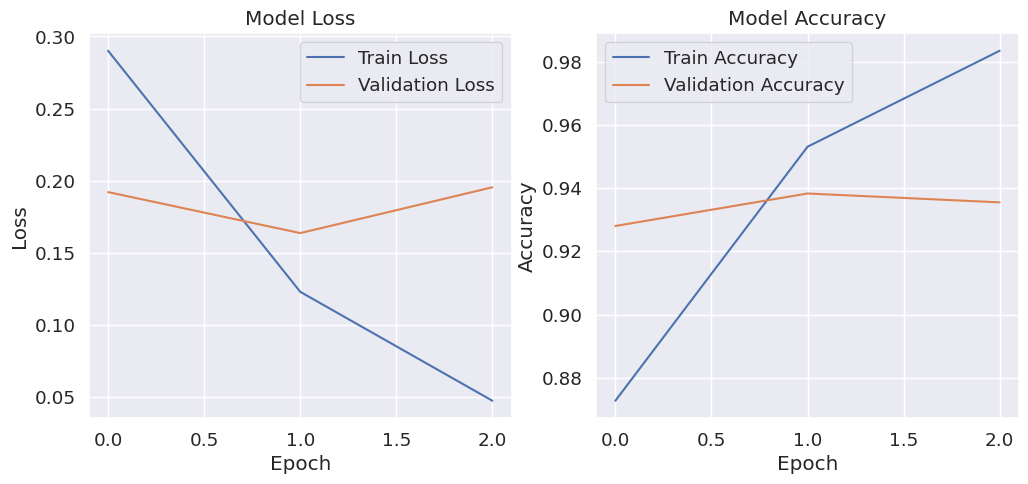

In [ ]:
plt.figure(figsize=(12, 5))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history_2_gru.history['loss'], label='Train Loss')
plt.plot(history_2_gru.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history_2_gru.history['accuracy'], label='Train Accuracy')
plt.plot(history_2_gru.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

67/67 [==============================] - 30s 279ms/step
Test Accuracy: 0.9317118802619271
F1 Score: 0.9353982300884954
Confusion Matrix:


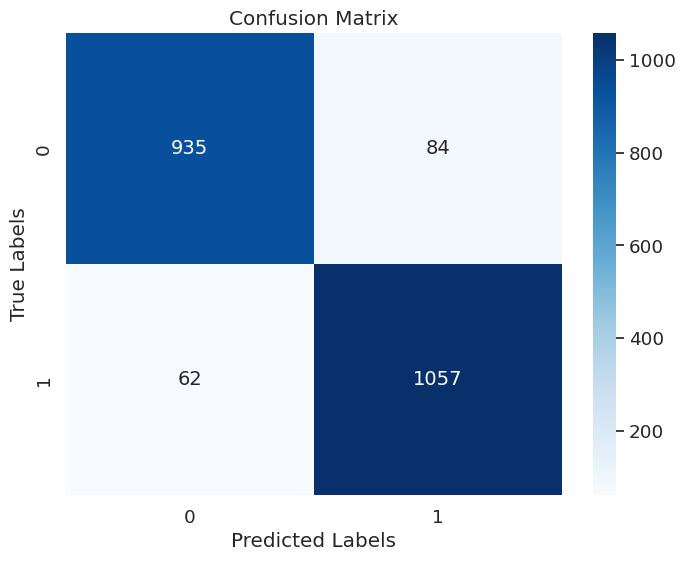

In [ ]:
predictions_2_feature = bert_gru_model_f.predict([test_input_ids, test_attention_mask, test_token_type_ids])
predicted_labels_2_feature = (predictions_2_feature > 0.5).astype(int).flatten()

# Calculate accuracy, F1 score, and confusion matrix
accuracy_2_feature = accuracy_score(test_target, predicted_labels_2_feature)
f1_2_feature = f1_score(test_target, predicted_labels_2_feature)
conf_matrix_2_feature = confusion_matrix(test_target, predicted_labels_2_feature)

print(f'Test Accuracy: {accuracy_2_feature}')
print(f'F1 Score: {f1_2_feature}')
print('Confusion Matrix:')
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix_2_feature, annot=True, fmt="d", cmap="Blues", annot_kws={"size": 14})

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

plt.show()

In [ ]:
predicted_real = predicted_labels_2_feature == 1
is_fake = test_target == 0
candidate = np.where(predicted_real & is_fake)

print(f"Tweet which predicted as real news but it is fake:\n {Test['tweet'][np.random.choice(candidate[0])]}")

Tweet which predicted as real news but it is fake: #CoronaVirusUpdates: #COVID19 testing status update: @ICMRDELHI stated that 60565728 samples tested upto September 16 2020 1136613 sample tested on September 16 2020 #StaySafe #IndiaWillWin https://t.co/oUcwFRtz6T


In [ ]:
predicted_fake = predicted_labels_2_feature == 0
is_real = test_target == 1
candidate = np.where(predicted_fake & is_real)

print(f"Tweet which predicted as fake news but it is real:\n {Test['tweet'][np.random.choice(candidate[0])]}")

Tweet which predicted as fake news but it is real:
 President Uhuru Kenyatta of Kenya ordered credit reference bureaus to delist Kenyans who had defaulted on loans to protect Kenyans from the economic effects of COVID-19.


## Feature-based: Model 3

In [ ]:
class CTBertBiGRUClassifierFeatureBased(tf.keras.Model):
    def __init__(self):
        super(CTBertBiGRUClassifierFeatureBased, self).__init__()
        self.bert = TFBertModel.from_pretrained('digitalepidemiologylab/covid-twitter-bert')
        self.bert.Trainable = False
        self.bi_gru = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64))
        self.dense = tf.keras.layers.Dense(1, activation='sigmoid')

    def call(self, inputs):
        input_ids, attention_mask, token_type_ids = inputs
        bert_output = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        last_hidden_state = bert_output.last_hidden_state
        x = self.bi_gru(last_hidden_state)
        x = self.dense(x)
        return x
    
ct_gru_model_f = CTBertBiGRUClassifierFeatureBased()

config.json:   0%|          | 0.00/421 [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/1.47G [00:00<?, ?B/s]

Some layers from the model checkpoint at digitalepidemiologylab/covid-twitter-bert were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at digitalepidemiologylab/covid-twitter-bert.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
ct_gru_model_f.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                      loss=tf.keras.losses.BinaryCrossentropy(),
                      metrics=['accuracy'])

history_2_ct_gru = ct_gru_model_f.fit([train_input_ids_ct, train_attention_mask_ct, train_token_type_ids_ct],
                                    train_target_ct,
                                    validation_data=([val_input_ids_ct, val_attention_mask_ct, val_token_type_ids_ct], val_target_ct),
                                    epochs=3,
                                    batch_size=4)

Epoch 1/3
1605/1605 [==============================] - 866s 463ms/step - loss: 0.2221 - accuracy: 0.9086 - val_loss: 0.1360 - val_accuracy: 0.9449
Epoch 2/3
1605/1605 [==============================] - 730s 455ms/step - loss: 0.0643 - accuracy: 0.9776 - val_loss: 0.1910 - val_accuracy: 0.9407
Epoch 3/3
1605/1605 [==============================] - 729s 454ms/step - loss: 0.0318 - accuracy: 0.9899 - val_loss: 0.1786 - val_accuracy: 0.9495


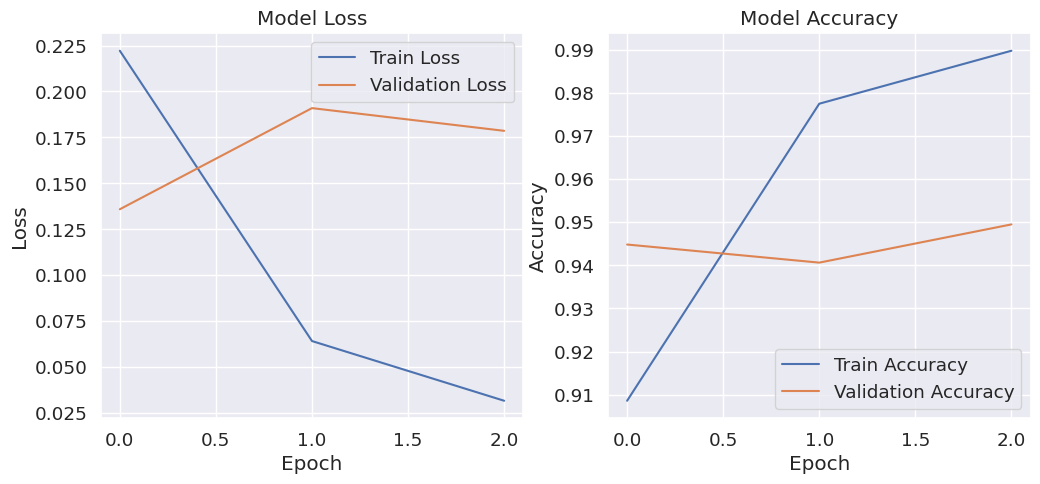

In [ ]:
plt.figure(figsize=(12, 5))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history_2_ct_gru.history['loss'], label='Train Loss')
plt.plot(history_2_ct_gru.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history_2_ct_gru.history['accuracy'], label='Train Accuracy')
plt.plot(history_2_ct_gru.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

67/67 [==============================] - 85s 925ms/step
Test Accuracy: 0.9550982226379794
F1 Score: 0.9571045576407506
Confusion Matrix:


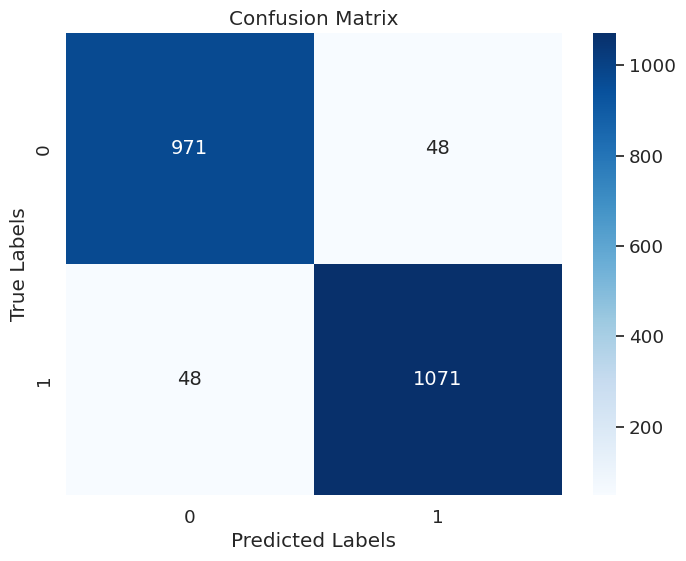

In [ ]:
predictions_3_feature = ct_gru_model_f.predict([test_input_ids_ct, test_attention_mask_ct, test_token_type_ids_ct])
predicted_labels_3_feature = (predictions_3_feature > 0.5).astype(int).flatten()

# Calculate accuracy, F1 score, and confusion matrix
accuracy_3_feature = accuracy_score(test_target_ct, predicted_labels_3_feature)
f1_3_feature = f1_score(test_target_ct, predicted_labels_3_feature)
conf_matrix_3_feature = confusion_matrix(test_target_ct, predicted_labels_3_feature)

print(f'Test Accuracy: {accuracy_3_feature}')
print(f'F1 Score: {f1_3_feature}')
print('Confusion Matrix:')
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix_3_feature, annot=True, fmt="d", cmap="Blues", annot_kws={"size": 14})

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

plt.show()

In [ ]:
predicted_real = predicted_labels_3_feature == 1
is_fake = test_target == 0
candidate = np.where(predicted_real & is_fake)

print(f"Tweet which predicted as real news but it is fake:\n {Test['tweet'][np.random.choice(candidate[0])]}")

Tweet which predicted as real news but it is fake:
 _Israel has no deaths from COVID-19; tea made of lemon and bicarbonate can cure coronavirus._


In [ ]:
predicted_fake = predicted_labels_3_feature == 0
is_real = test_target == 1
candidate = np.where(predicted_fake & is_real)

print(f"Tweet which predicted as fake news but it is real:\n {Test['tweet'][np.random.choice(candidate[0])]}")

Tweet which predicted as fake news but it is real:
 There are four patients with COVID-19 in Middlemore Hospital. Two are stable and each of these is in isolation on a ward. Two are in ICU and are in critical condition. These are the same four patients previously reported and are all part of the community cluster.
